### SSH based plots and sections 


In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [18]:
def datetime2ytd(time):
    """" Return time in YTD format from datetime format."""
    return  (time - np.datetime64('2019-01-01'))/np.timedelta64(1, 'D')
    

In [15]:
ds_660_z = xr.open_dataset('data/ctd_660_vert_4m_binned_29_june_2021.nc')
# Calculate a time axis as YTD
ds_660_z['days'] = datetime2ytd(ds_660_z.time)

In [4]:
ds_SSH = xr.open_dataset('/Users/dhruvbalwada/OneDrive/sogos_data/data/for_dashboard/SSH_sogos.nc')
ds_SSH = ds_SSH.assign_coords(days = datetime2ytd(ds_SSH.time))

In [26]:
ds_660_z['days'].min().values, ds_660_z['days'].max().values, (ds_660_z['days'].max() - ds_660_z['days'].min()).values


(array(119.51065633), array(205.98735772), array(86.47670138))

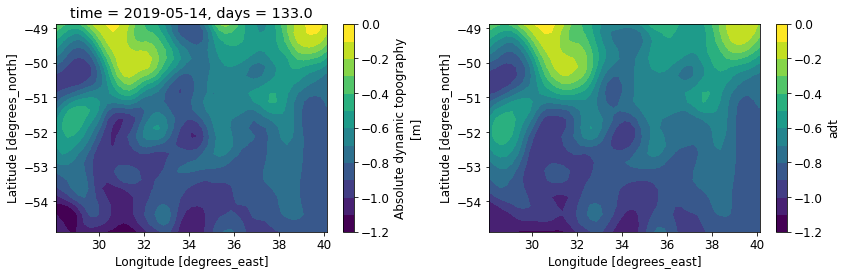

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
ds_SSH.adt.isel(time=15).plot.contourf(levels=np.linspace(-1.2,0, 13))

plt.subplot(122)
ds_SSH.adt.isel(time=slice(0, 30)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13))

plt.tight_layout()

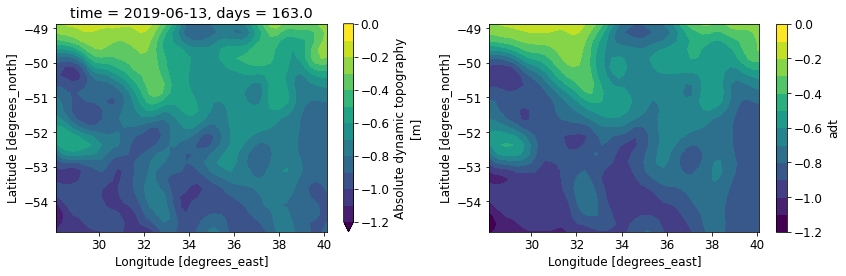

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
ds_SSH.adt.isel(time=45).plot.contourf(levels=np.linspace(-1.2,0, 13))

plt.subplot(122)
ds_SSH.adt.isel(time=slice(30, 60)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13))

plt.tight_layout()

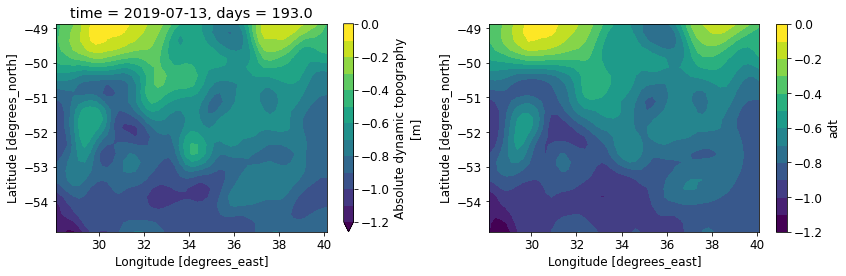

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
ds_SSH.adt.isel(time=75).plot.contourf(levels=np.linspace(-1.2,0, 13))

plt.subplot(122)
ds_SSH.adt.isel(time=slice(60, 90)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13))

plt.tight_layout()

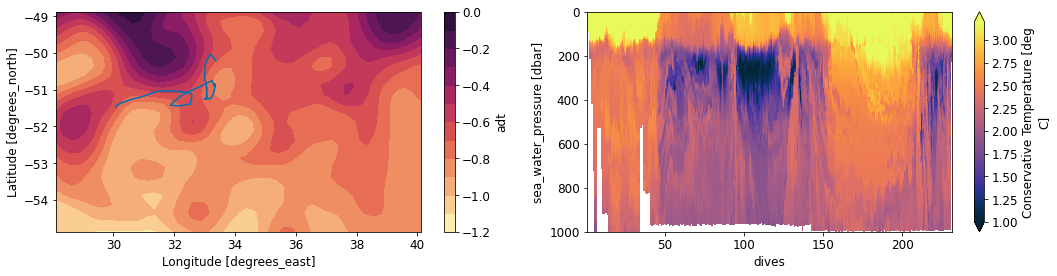

In [75]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
ds_SSH.adt.isel(time=slice(0, 30)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
plt.plot(ds_660_z.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_z.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').latitude)

plt.subplot(122)
ds_660_z.where(ds_660_z.days<=150, drop=True).CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()

plt.savefig('./figures/ssh_sec1.pdf')

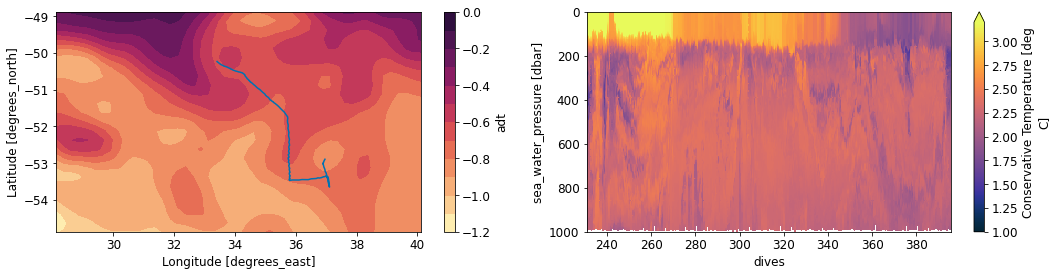

In [77]:
plt.figure(figsize=(15, 4))

ds_660_sel = ds_660_z.where( (ds_660_z.days>=150) & (ds_660_z.days<=180), drop=True)

plt.subplot(121)
ds_SSH.adt.isel(time=slice(30, 60)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
plt.plot(ds_660_sel.sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_sel.sel(ctd_pressure=200, method='nearest').latitude)

plt.subplot(122)
ds_660_sel.CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('./figures/ssh_sec2.pdf')

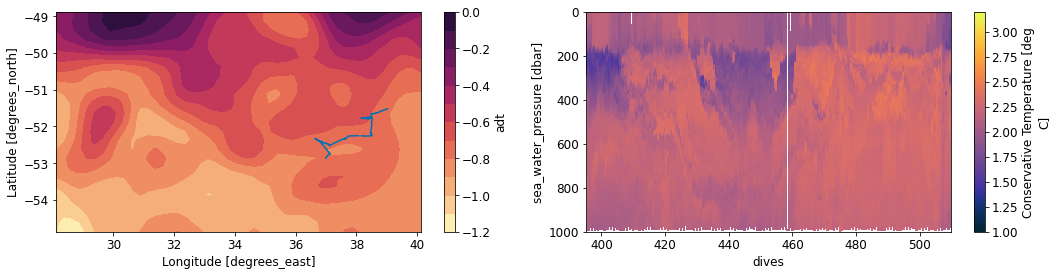

In [79]:
plt.figure(figsize=(15, 4))

ds_660_sel = ds_660_z.where( (ds_660_z.days>=180), drop=True)

plt.subplot(121)
ds_SSH.adt.isel(time=slice(60, 90)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
plt.plot(ds_660_sel.sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_sel.sel(ctd_pressure=200, method='nearest').latitude)

plt.subplot(122)
ds_660_sel.CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('./figures/ssh_sec3.pdf')

In [ ]:
ds_660_z.where(.sel(ctd_pressure=100, method='nearest').longitude

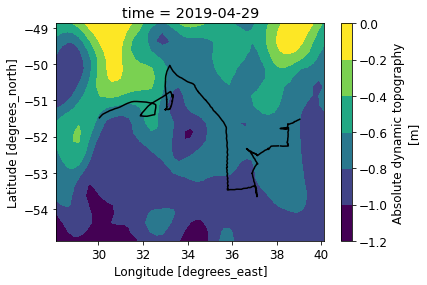

In [17]:
ds_SSH.adt.isel(time=0).plot.contourf()
plt.plot(ds_660_z.sel(ctd_pressure=100, method='nearest').longitude,
         ds_660_z.sel(ctd_pressure=100, method='nearest').latitude,
         color='k')

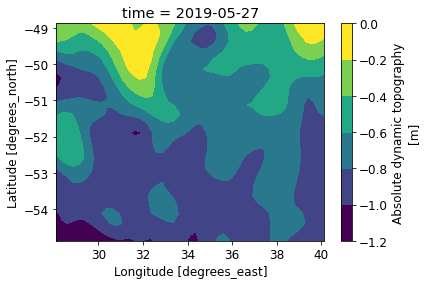

In [8]:
ds_SSH.adt.isel(time=28).plot.contourf()